<a href="https://colab.research.google.com/github/thamadziripi/random-forest-corporate-bonds-profiling/blob/main/random_forest_corporate_bonds_profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Corporate Bond Profiling using PCA, K-Means and Random Forest

In [ ]:
# General modules
import pandas as pd
import numpy as np
from datetime import datetime

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# for PCA/K-means/Random forest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Suppressing scientific notations
pd.options.display.float_format = '{:.3f}'.format

# Data Extraction

First step is to extract our data set. We use the BoE's QE programme dataset which is publicaly available on the bank of england. The xlsx file consists of 4 tabs. For our analysis, we will only look at corporate bond purchase auction data. For more information, please visit the Bank of England website.

In [ ]:
file_url = "https://www.bankofengland.co.uk/-/media/boe/files/statistics/research-datasets/qe-related-data.xlsx"
sheet = "Corp Bond Purchase Auction Data"

In [ ]:
corp_bonds = pd.read_excel(io=file_url, sheet_name=sheet, header=3, nrows=36800,
                           na_values="-", parse_dates=["Settlement date"])
corp_bonds.head()

,Operation date,Ticker (d)\n,ISIN,Reference instrument,Reference yield (%),Settlement date,Total offers received (nominal £mn),Allocation (nominal £mn),Allocation (proceeds £mn),Clearing spread (bps)(a),Clearing yield (%),Clearing price (£)(b),Allocated at clearing spread (%)(c)
0,2009-03-25,AALLN 6 7/8 05/01/18,XS0361024895,UKT 5 03/18,3.210,2009-03-30,38.000,5.200,4.970,523.000,8.440,89.293,NaN
1,2009-03-25,BATSLN 6 3/8 12/12/19,XS0182188366,UKT 4.5 03/19,3.379,2009-03-30,5.000,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-03-25,BRITEL 6 5/8 06/23/17,XS0306772939,UKT 4 09/16,2.888,2009-03-30,31.800,5.100,4.960,491.000,7.798,92.165,NaN
3,2009-03-25,BRITEL 8 5/8 03/26/20,XS0052067583,UKT 4.75 03/20,3.551,2009-03-30,11.000,4.900,4.970,472.000,8.271,101.274,NaN
4,2009-03-25,BRK 8 7/8 10/16/20,XS0060490017,UKT 4.75 03/20,3.551,2009-03-30,4.600,1.500,1.890,250.000,6.051,122.066,NaN


# Data cleaning

Next we need to handle the Null values that are present in our dataset. We can either take the mean, replace with 0's or drop any rows that contain null's. For our analysis, we will drop any rows that contain nulls and tidy up the dataset.

In [ ]:
corp_bonds.isnull().sum()

Operation date                             0
Ticker (d)\n                               0
ISIN                                       0
Reference instrument                    1826
Reference yield (%)                     1826
Settlement date                            0
Total offers received (nominal £mn)        0
Allocation (nominal £mn)               36105
Allocation (proceeds £mn)              36105
Clearing spread (bps)(a)               34279
Clearing yield (%)                     36105
Clearing price (£)(b)                  36105
Allocated at clearing spread (%)(c)    36369
dtype: int64

In [ ]:
tidy_bonds = corp_bonds.copy()
tidy_bonds.drop(["Operation date", "Settlement date", "ISIN", "Reference instrument"], axis=1, inplace=True)
tidy_bonds.set_index(["Ticker (d)\n"], inplace=True)
tidy_bonds.dropna(inplace=True)
#tidy_bonds = tidy_bonds.groupby(["Ticker (d)\n"]).mean(numeric_only=True)

We now have 431 observations with no null values. We have also constrained the dataset to numerical columns.

In [ ]:
tidy_bonds.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, RWE 6 1/4 06/03/30 to MOTOPG 6 5/8 12/10/19
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Reference yield (%)                  431 non-null    float64
 1   Total offers received (nominal £mn)  431 non-null    float64
 2   Allocation (nominal £mn)             431 non-null    float64
 3   Allocation (proceeds £mn)            431 non-null    float64
 4   Clearing spread (bps)(a)             431 non-null    float64
 5   Clearing yield (%)                   431 non-null    float64
 6   Clearing price (£)(b)                431 non-null    float64
 7   Allocated at clearing spread (%)(c)  431 non-null    float64
dtypes: float64(8)
memory usage: 30.3+ KB


### Standardizing

We'll need to prepare our data for dimension reduction using PCA. To do  this we will scale our dataset using the StandardScalar function from sklearn. This will scale the dataset such that each column has a 0 mean and the same standard deviation.

In [ ]:
scaler = StandardScaler()
std_data = scaler.fit_transform(tidy_bonds)

std_df = pd.DataFrame(std_data, columns=tidy_bonds.columns)
std_df.describe()

,Reference yield (%),Total offers received (nominal £mn),Allocation (nominal £mn),Allocation (proceeds £mn),Clearing spread (bps)(a),Clearing yield (%),Clearing price (£)(b),Allocated at clearing spread (%)(c)
count,431.000,431.000,431.000,431.000,431.000,431.000,431.000,431.000
mean,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,-2.587,-0.957,-1.165,-1.315,-1.929,-2.975,-2.417,-6.251
25%,-0.729,-0.659,-0.695,-0.695,-0.718,-0.664,-0.604,0.289
50%,0.263,-0.330,-0.494,-0.420,-0.162,0.243,-0.274,0.289
75%,0.885,0.238,1.449,1.106,0.362,0.753,0.454,0.289
max,1.381,4.719,1.516,2.430,4.310,2.648,3.422,0.289


# PCA dimension reduction

Principle component analysis (PCA) is one of the oldest and most widely used methods for significantly reducing dimensionality (Jolliffe and Cadima 2016, p.1). Dimension reduction is important in instances where there are many variables in a dataset. PCA helps to summarise the dataset into a group of principle components.

We firstly start by showing all the components so we can plot them against their respective explained variances.

In [ ]:
pca = PCA()
pca.fit(std_df)

PCA()

### Visualizing explained variance

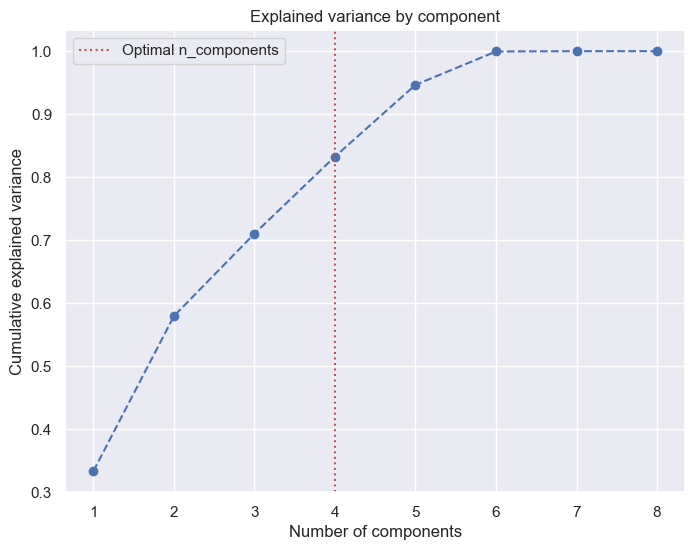

In [ ]:
n_components = len(pca.explained_variance_ratio_)
pca_cumulative = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 6))
plt.plot(range(1, n_components+1), pca_cumulative, marker="o", linestyle="--")
plt.axvline(x = 4, color = 'r', label = 'Optimal n_components', linestyle="dotted")
plt.title("Explained variance by component")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.legend()
plt.show();

We want to preserve 80% of the explained variance. In which case, we will select 4 as our number of components based on the graph above.

In [ ]:
pca = PCA(n_components=4)
pca.fit(std_df)

PCA(n_components=4)

In [ ]:
# Print explained variance ratio
for n, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"* PC{n + 1} explained variance ratio:{ratio:.2%}")

# Total explained variance
print(f"\nTotal explained variance: {sum(pca.explained_variance_ratio_):.2%}")

* PC1 explained variance ratio:33.32%
* PC2 explained variance ratio:24.62%
* PC3 explained variance ratio:13.08%
* PC4 explained variance ratio:12.25%

Total explained variance: 83.26%


In [ ]:
# We want to be able to fit our K-means using our PCA scores instead of the original features
pca_scores = pca.transform(std_df)

# K-means

K-means clustering is typically used to partition unlabelled data points into a pre-defined number of clusters. The aim is to ensure that each data point is as close to as possible to the corresponding centroid. Centroids are determined by the value K, which also refers to the maximum number of clusters. K-means requires some knowledge of what the value of K should be. We used the elbow curve approach to identify the optimal number for K

In [ ]:
wcss = []
for k in range(1, 10):
   kmeans = KMeans(n_clusters=k, init ='k-means++', verbose=0, n_init=10, random_state=42)
   kmeans.fit(pca_scores)
   wcss.append(kmeans.inertia_)

### Plotting K means with PCA clusters

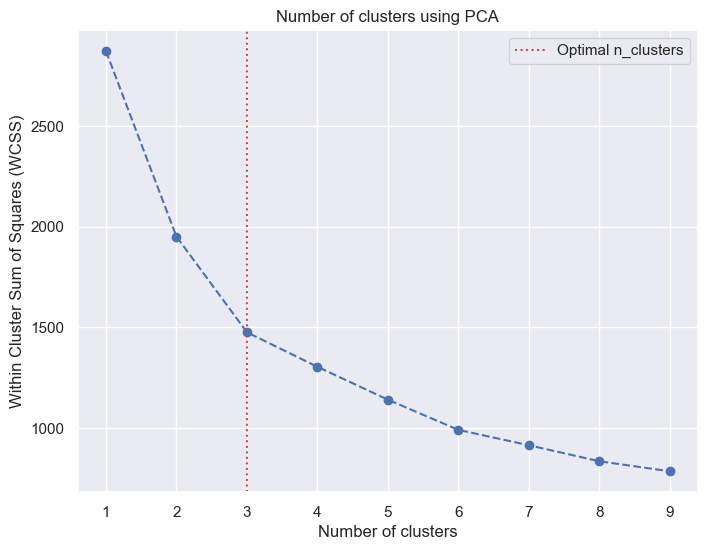

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), wcss, marker="o", linestyle="--")
plt.axvline(x = 3, color = 'r', label = 'Optimal n_clusters', linestyle="dotted")
plt.title("Number of clusters using PCA")
plt.xlabel("Number of clusters")
plt.ylabel("Within Cluster Sum of Squares (WCSS)")
plt.legend()
plt.show();

### K-means using optimal number of clusters

In [ ]:
kmeans_pca = KMeans(n_clusters=3, init ='k-means++', verbose=0, n_init=10, random_state=42)
kmeans_pca.fit(pca_scores)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [ ]:
# Next we need to create a join the PCA scores to the original values and populate their
#  PCA cluster
pca_df = pd.DataFrame(pca_scores, columns=["Component 1", "Component 2", "Component 3", "Component 4"])
bonds_kmeans = pd.concat([tidy_bonds.reset_index(), pca_df], axis=1)
bonds_kmeans["Predicted Cluster"] = kmeans_pca.labels_

# Need to map the values to cluster names
bonds_kmeans["Predicted Cluster"] = bonds_kmeans["Predicted Cluster"].map({0:"Cluster 1",
                                                                           1:"Cluster 2",
                                                                           2:"Cluster 3"})

bonds_kmeans.head()

,Ticker (d)\n,Reference yield (%),Total offers received (nominal £mn),Allocation (nominal £mn),Allocation (proceeds £mn),Clearing spread (bps)(a),Clearing yield (%),Clearing price (£)(b),Allocated at clearing spread (%)(c),Component 1,Component 2,Component 3,Component 4,Predicted Cluster
0,RWE 6 1/4 06/03/30,4.199,3.000,3.000,3.400,100.000,5.199,112.230,100.000,-0.049,-1.545,-0.851,-0.501,Cluster 1
1,CENTRI 7 09/19/33,4.198,1.800,1.800,2.250,130.000,5.498,118.646,100.000,-1.047,-1.590,-0.667,0.523,Cluster 1
2,DT 6 1/2 04/08/22,3.805,4.200,2.200,2.400,183.000,5.635,106.894,100.000,-0.295,-1.126,0.975,0.393,Cluster 1
3,RWE 6 1/4 06/03/30,4.109,1.900,1.900,2.170,103.000,5.139,113.058,100.000,-1.072,-1.491,-0.728,-0.377,Cluster 1
4,UU 6 1/8 12/29/15,2.900,1.000,1.000,1.130,152.000,4.420,108.960,100.000,-1.923,0.020,0.262,-0.213,Cluster 1


### Visualize clusters

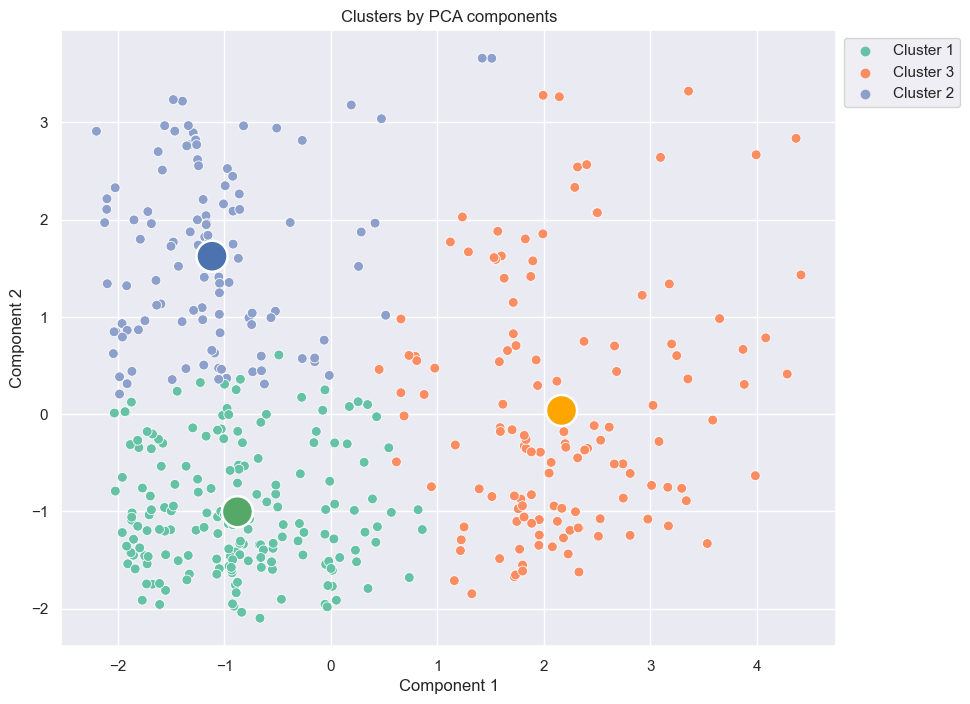

In [ ]:
centroids = kmeans_pca.cluster_centers_

plt.figure(figsize=(10, 8))
# Original clusters
sns.scatterplot(x="Component 1", y="Component 2", data=bonds_kmeans, s=50,
                hue="Predicted Cluster", palette="Set2")
# Centroids
sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker="o", s=500,
               c=["g", "b", "orange"])
plt.title("Clusters by PCA components")
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show();

### Parallel Coordinates

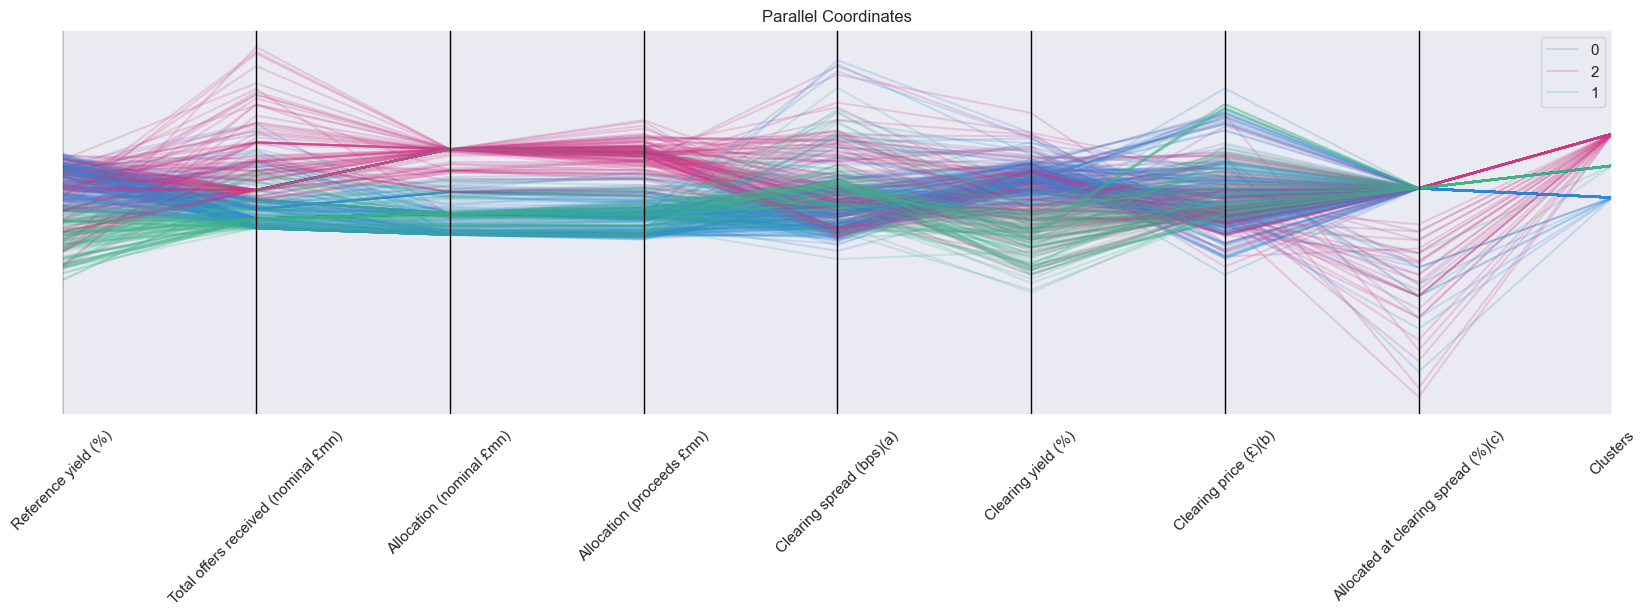

In [ ]:
x = std_df
x["Clusters"] = kmeans_pca.labels_

fig, ax = plt.subplots(figsize=(20, 5), dpi=100)
pd.plotting.parallel_coordinates(frame=x, class_column="Clusters", cols=list(x.columns) ,
                                 color=['#2e8ad8', '#cd3785', '#3eb489'], sort_labels=True, axvlines=True,
                                 alpha=0.2, ax=ax, linestyle="-")
plt.title("Parallel Coordinates")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.axes.get_yaxis().set_visible(False)
plt.show()

# Supervised learning: Random forest model

In [ ]:
# Preparing x and y data for random forest
x = bonds_kmeans.iloc[:,1:9]
y = bonds_kmeans["Predicted Cluster"]
x.head()

,Reference yield (%),Total offers received (nominal £mn),Allocation (nominal £mn),Allocation (proceeds £mn),Clearing spread (bps)(a),Clearing yield (%),Clearing price (£)(b),Allocated at clearing spread (%)(c)
0,4.199,3.000,3.000,3.400,100.000,5.199,112.230,100.000
1,4.198,1.800,1.800,2.250,130.000,5.498,118.646,100.000
2,3.805,4.200,2.200,2.400,183.000,5.635,106.894,100.000
3,4.109,1.900,1.900,2.170,103.000,5.139,113.058,100.000
4,2.900,1.000,1.000,1.130,152.000,4.420,108.960,100.000


In [ ]:
# Splitting into train and testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

print(f"Training dataset shape:{X_train.shape}")
print(f"Testing dataset shape:{X_test.shape}")

Training dataset shape:(301, 8)
Testing dataset shape:(130, 8)


In [ ]:
# Creating our random forest classifier model
clf = RandomForestClassifier(random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

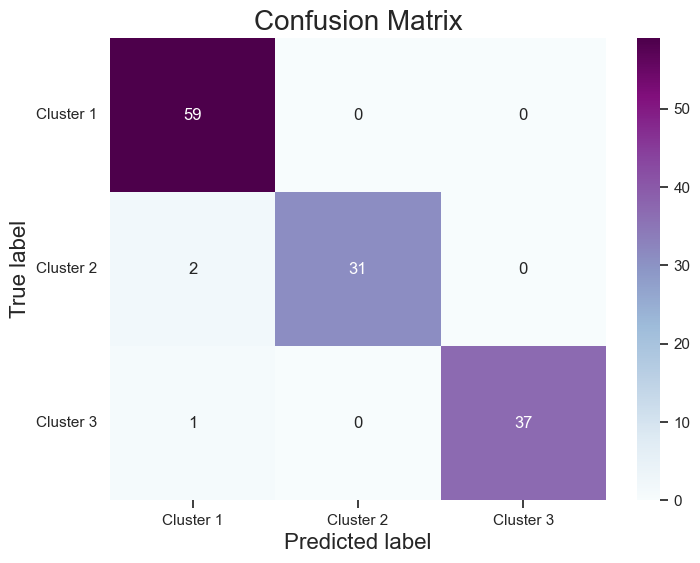

In [ ]:
# Make predictions
y_pred = clf.predict(X_test)

# Create confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Plot heatmap
fig = plt.figure(figsize=(8, 6))
ax= plt.subplot()
sns.heatmap(cf_matrix, ax = ax, annot=True, cmap="BuPu")

ax.set_xlabel('Predicted label', fontsize=16)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=0)
ax.xaxis.tick_bottom()
ax.xaxis.set_ticklabels(['Cluster 1', 'Cluster 2', "Cluster 3"]);

ax.set_ylabel('True label', fontsize=16)
ax.yaxis.set_ticklabels(['Cluster 1', 'Cluster 2', "Cluster 3"]);
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=20)
plt.show;

In [ ]:
print(f"Model Accuracy score: {accuracy_score(y_test, y_pred):.2%}")

Model Accuracy score: 97.69%


# References

Jolliffe, I. and Cadima, J. (2016). 'Principal component analysis: a review and recent developments', Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 374 (2065), p.20150202.